In [7]:
dir = 'D:/projects/datascience/bfu-ml-labs/lab_6'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from sklearn.datasets import make_blobs

In [9]:
g_n_samples = 500
g_random_state = 0

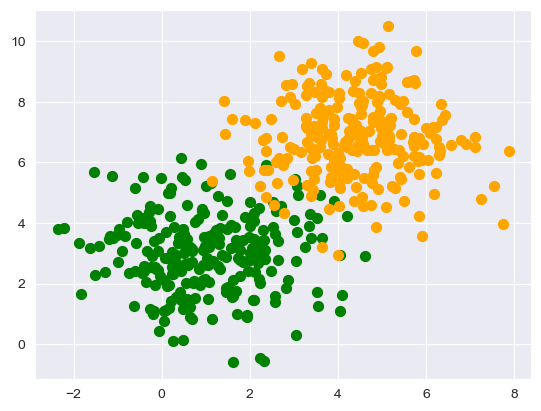

In [10]:
data, labels = make_blobs(
    n_samples=g_n_samples,
    centers=([1.1, 3], [4.5, 6.9]),
    cluster_std=1.3,
    random_state=g_random_state
)

colours = ('green', 'orange')
fig, ax = plt.subplots()

for n_class in range(2):
    ax.scatter(
        data[labels == n_class][:, 0],
        data[labels == n_class][:, 1],
        c=colours[n_class],
        s=50,
        label=str(n_class)
    )

In [11]:
df = pd.DataFrame(data, columns=['f1', 'f2'])
df['target'] = labels

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      500 non-null    float64
 1   f2      500 non-null    float64
 2   target  500 non-null    int32  
dtypes: float64(2), int32(1)
memory usage: 9.9 KB


In [7]:
df.head()

,f1,f2,target
0,6.226118,6.768334,1
1,1.048932,1.481478,0
2,2.873891,2.103716,0
3,-0.780495,4.040387,0
4,4.037102,2.945066,0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df.drop(['target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 2), (100, 2), (400,), (100,))

In [9]:
class WeightsInit:
    @staticmethod
    def zeroes(n: int, _random_state: float) -> np.ndarray:
        return np.zeros(shape=(n, ))

    @staticmethod
    def random(n: int, random_state: float) -> np.ndarray:
        rng = np.random.default_rng(random_state)
        return rng.uniform(0., 1., n)



class ActivationFunc:
    @staticmethod
    @np.vectorize
    def step(wsum: float) -> float:
        return 1. if wsum > 0. else 0.

    @staticmethod
    @np.vectorize
    def sigmoid(wsum: float) -> float:
        return 1. / (1. + np.exp(-wsum))

    @staticmethod
    @np.vectorize
    def tanh(wsum: float) -> float:
        return (np.exp(wsum) - np.exp(-wsum)) / (np.exp(wsum) + np.exp(-wsum))


class Perceptron:
    def __init__(
        self,
        *,
        weights: Callable = WeightsInit.random,
        activation: Callable = ActivationFunc.step,
        threshold: float = 0.5,
        random_state: int = 0,
        n_epochs: int = 10,
        learning_rate: float = 0.3,
    ):
        self.weights_init = weights
        self.activation_func = activation
        self.threshold = threshold
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state

        self.weights_: np.ndarray = None

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        self.weights_ = self.weights_init(X.shape[1] + 1, self.random_state)

        for epoch in range(self.n_epochs):
            for i, x_i in X.iterrows():
                y_i_pred = self.predict(x_i.to_frame().T)
                x_i_p = np.insert(x_i.values, 0, 1.)
                self.weights_ += self.learning_rate * (y[i] - y_i_pred) * x_i_p

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        X = np.hstack((np.ones(shape=(X.shape[0], 1)), X))
        a = self.activation_func(np.dot(X, self.weights_))
        return np.where(a > self.threshold, 1, 0)

    def score(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        return accuracy_score(y, self.predict(X))

    # noinspection PyUnusedLocal
    def get_params(self, deep=True):
        return {
            'weights': self.weights_init,
            'activation': self.activation_func,
            'threshold': self.threshold,
            'n_epochs': self.n_epochs,
            'learning_rate': self.learning_rate,
            'random_state': self.random_state,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [10]:
from sklearn.model_selection import validation_curve


metric = 'accuracy'


def experiment_with_model_hyperparameter(model, param_name, param_range):
    train_scores, test_scores = validation_curve(
        model,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        cv=3,
        scoring=metric,
    )

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)

    print(test_scores.max())

    plt.figure(figsize=(10, 5))

    plt.plot(param_range, train_scores_mean, label='Train')
    plt.plot(param_range, test_scores_mean, label='Test')
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.25)
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.25)

    plt.xticks(param_range)
    plt.yticks(np.arange(0., 1., 0.05))
    plt.xlabel(param_name)
    plt.ylabel(metric)
    plt.legend()
    plt.show()

0.9700598802395209


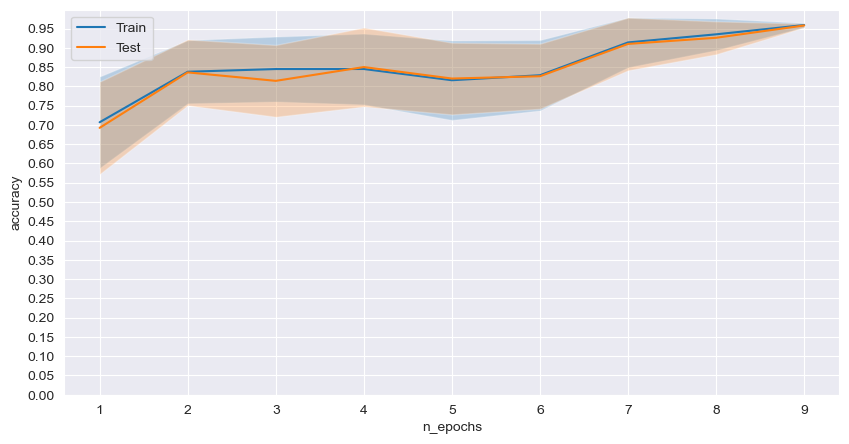

In [11]:
experiment_with_model_hyperparameter(Perceptron(random_state=g_random_state), 'n_epochs', np.arange(1, 10))

0.9760479041916168


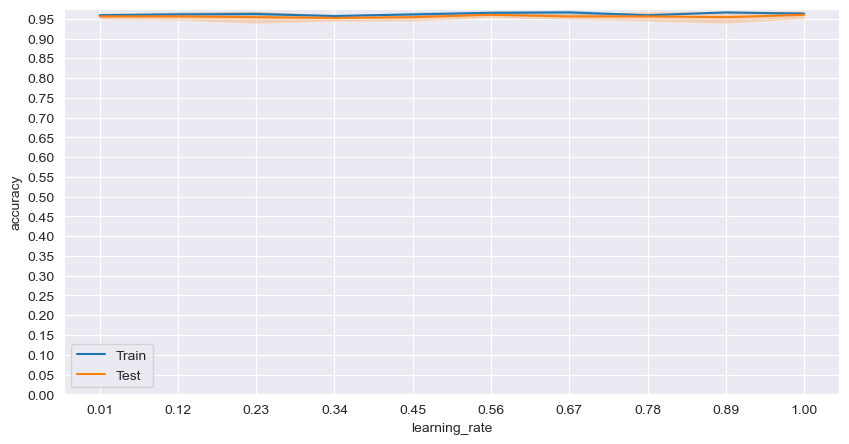

In [12]:
experiment_with_model_hyperparameter(Perceptron(random_state=g_random_state), 'learning_rate', np.linspace(0.01, 1., 10))

0.9760479041916168


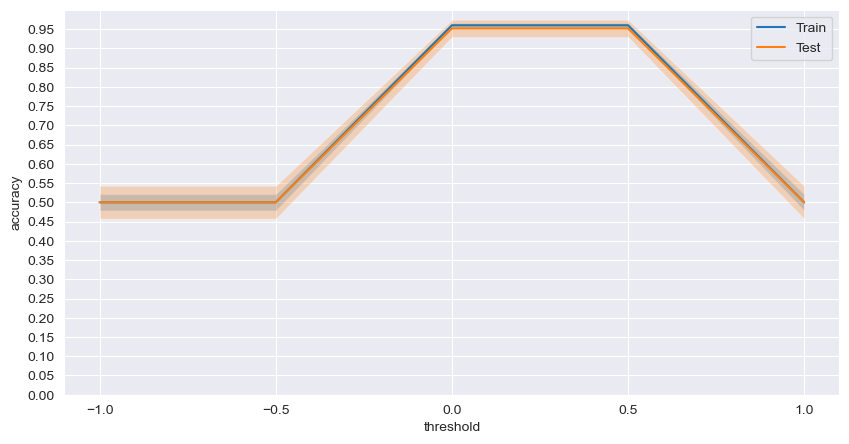

In [16]:
experiment_with_model_hyperparameter(Perceptron(random_state=g_random_state, activation=ActivationFunc.step),
                                     'threshold', np.linspace(-1., 1., 5, endpoint=True))

C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:22: RuntimeWarning: overflow encountered in exp

0.9760479041916168


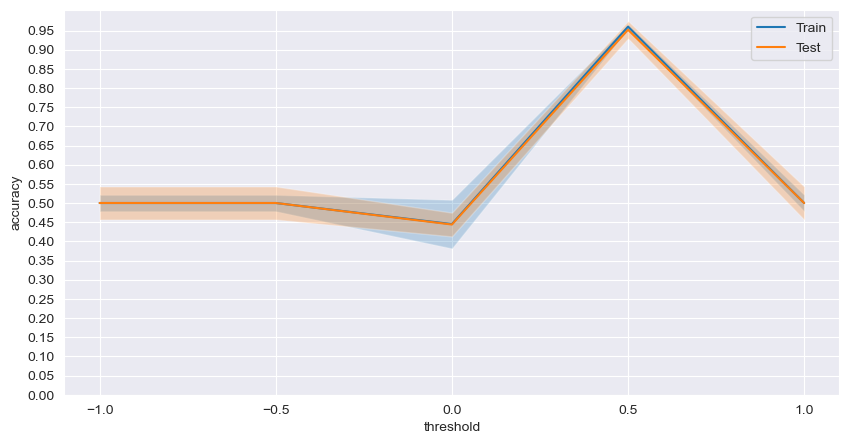

In [17]:
experiment_with_model_hyperparameter(Perceptron(random_state=g_random_state, activation=ActivationFunc.sigmoid),
                                     'threshold', np.linspace(-1., 1., 5, endpoint=True))

C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:27: RuntimeWarning: overflow encountered in exp
  return (np.exp(wsum) - np.exp(-wsum)) / (np.exp(wsum) + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return (np.exp(wsum) - np.exp(-wsum)) / (np.exp(wsum) + np.exp(-wsum))
D:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2412: RuntimeWarning: invalid value encountered in tanh (vectorized)
  outputs = ufunc(*inputs)
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:27: RuntimeWarning: overflow encountered in exp
  return (np.exp(wsum) - np.exp(-wsum)) / (np.exp(wsum) + np.exp(-wsum))
C:\Users\German\AppData\Local\Temp\ipykernel_18740\1676656870.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return (np.exp(wsum) - np.exp(-wsum)) / (np.exp(wsum) + np.exp(-wsum))
D:\anaconda3\lib\site-packages\numpy\lib\function_base.py:2412: RuntimeW

0.9760479041916168


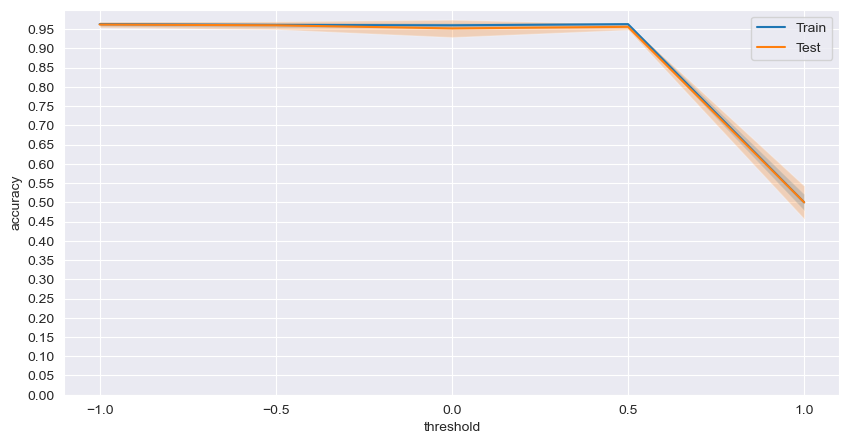

In [18]:
experiment_with_model_hyperparameter(Perceptron(random_state=g_random_state, activation=ActivationFunc.tanh),
                                     'threshold', np.linspace(-1., 1., 5, endpoint=True))

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_epochs': [1, 20],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.],
}

grid_search = GridSearchCV(Perceptron(random_state=g_random_state), param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=<__main__.Perceptron object at 0x0000019B9016A970>,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0],
                         'n_epochs': [1, 20]})

In [21]:
grid_search.best_params_

{'learning_rate': 1.0, 'n_epochs': 20}

In [22]:
grid_search.best_score_

0.9350428309579919

In [23]:
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       1.00      0.98      0.99        57

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



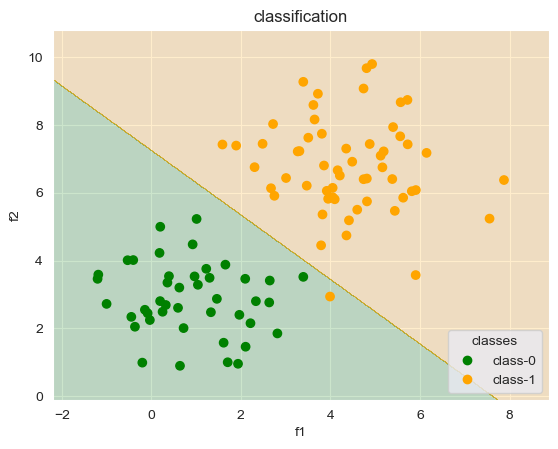

In [24]:
from matplotlib.colors import ListedColormap

mesh_f1, mesh_f2 = np.meshgrid(
    np.linspace(X_test['f1'].min() - 1., X_test['f1'].max() + 1., 1000),
    np.linspace(X_test['f2'].min() - 1., X_test['f2'].max() + 1., 1000)
)

mesh_X_test_data = np.c_[mesh_f1.ravel(), mesh_f2.ravel()]
mesh_X_test = pd.DataFrame(mesh_X_test_data, columns=['f1', 'f2'])
mesh_y_pred = grid_search.best_estimator_.predict(mesh_X_test).reshape(mesh_f1.shape)

cmap = ListedColormap(colours)

plt.contourf(mesh_f1, mesh_f2, mesh_y_pred, alpha=0.2, cmap=cmap)
scatter = plt.scatter(X_test['f1'], X_test['f2'], c=y_test, cmap=cmap)

plt.xlim(mesh_f1.min(), mesh_f1.max())
plt.ylim(mesh_f2.min(), mesh_f2.max())
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend(
    handles=scatter.legend_elements()[0],
    title='classes',
    labels=['class-0', 'class-1'],
    loc='lower right'
)
plt.title('classification')

plt.show()

In [13]:
from sklearn.linear_model import Perceptron as SklPerceptron
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'eta0': [0.01, 0.1, 1.],
    'alpha': [0.01, 0.1, 1.],
    'max_iter': [100, 1000, 1000],
}

grid_search = GridSearchCV(SklPerceptron(random_state=g_random_state), param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Perceptron(),
             param_grid={'alpha': [0.01, 0.1, 1.0], 'eta0': [0.01, 0.1, 1.0],
                         'max_iter': [100, 1000, 1000],
                         'penalty': [None, 'l2', 'l1', 'elasticnet']})

In [14]:
grid_search.best_params_

{'alpha': 0.01, 'eta0': 0.01, 'max_iter': 100, 'penalty': 'elasticnet'}

In [15]:
grid_search.best_score_

0.9624995324131224

In [17]:
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        44
           1       0.88      1.00      0.93        56

    accuracy                           0.92       100
   macro avg       0.94      0.91      0.92       100
weighted avg       0.93      0.92      0.92       100



In [18]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
df = iris.frame.tail(100)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 50 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  100 non-null    float64
 1   sepal width (cm)   100 non-null    float64
 2   petal length (cm)  100 non-null    float64
 3   petal width (cm)   100 non-null    float64
 4   target             100 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 3.6 KB


In [19]:
X = df.drop(['target'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((75, 4), (25, 4), (75,), (25,))

In [27]:
param_grid = {
    'penalty': [None, 'l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-4],
    'early_stopping': [True, False],
}

grid_search = GridSearchCV(SklPerceptron(random_state=g_random_state), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))

{'alpha': 0.001, 'early_stopping': False, 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
0.96
              precision    recall  f1-score   support

           1       0.81      0.97      0.89        36
           2       0.97      0.79      0.87        39

    accuracy                           0.88        75
   macro avg       0.89      0.88      0.88        75
weighted avg       0.89      0.88      0.88        75



In [28]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(SVC(random_state=g_random_state), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.9866666666666667
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        36
           2       0.95      1.00      0.97        39

    accuracy                           0.97        75
   macro avg       0.98      0.97      0.97        75
weighted avg       0.97      0.97      0.97        75

